In [1]:
# Image Folders
# Learning rate scheduler
# Transfer learning

In [2]:
# Image data folder structure
# - data/hymenoptera_data/
#   - train/
#       - ants/
#       - bees/
#   - val/
#       - ants/
#       - bees/

In [3]:
import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.optim import lr_scheduler
import numpy as np
import torchvision 
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy     

In [4]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [6]:
data_dir = './data/hymenoptera_data/'

image_datasets  = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
    for x in ['train', 'val']
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=0)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

In [7]:
print(dataset_sizes)
print(class_names)

{'train': 244, 'val': 153}
['ants', 'bees']


In [8]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

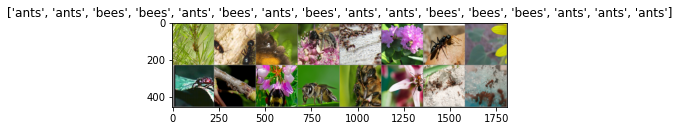

In [9]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print("-"*10)

        # Each epoch has training + validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward
                # Only track history if in train mode
                with torch.set_grad_enabled(phase=="train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in train phase
                    if phase == "train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step() 
            
                # stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == "train":
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

            # Deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print()

    time_elapsed = time.time() - since 
    print(f"Training completed in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f'Best val acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model 

In [12]:
# Option 1 Fine-tuning the convnet
# Load a pretrained model and reset final fully connected layer

In [13]:
model = models.resnet18(pretrained=True)

In [14]:
model.fc.in_features

512

In [15]:
num_features = model.fc.in_features

In [16]:
model.fc = nn.Linear(num_features, 2) # two classes: ants, bees

In [17]:
model = model.to(device)

In [18]:
criterion = nn.CrossEntropyLoss()

In [19]:
# Notice that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [20]:
# StepLR decays the learning rate of each param group by gamma every step_size epochs
# e.g. decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer's update:
# for epoch in range(100):
#   train(...)
#   validate(...)
#   scheduler.step()

In [21]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [22]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.6950, Acc: 0.5369
val Loss: 0.6564, Acc: 0.5882
Epoch 2/10
----------
train Loss: 0.6116, Acc: 0.6844
val Loss: 0.5554, Acc: 0.7451
Epoch 3/10
----------
train Loss: 0.5360, Acc: 0.7541
val Loss: 0.4749, Acc: 0.8105
Epoch 4/10
----------
train Loss: 0.4947, Acc: 0.7992
val Loss: 0.4394, Acc: 0.8431
Epoch 5/10
----------
train Loss: 0.4299, Acc: 0.8402
val Loss: 0.3825, Acc: 0.8889
Epoch 6/10
----------
train Loss: 0.4117, Acc: 0.8279
val Loss: 0.3590, Acc: 0.8889
Epoch 7/10
----------
train Loss: 0.3675, Acc: 0.8893
val Loss: 0.3329, Acc: 0.9150
Epoch 8/10
----------
train Loss: 0.3639, Acc: 0.8443
val Loss: 0.3318, Acc: 0.9020
Epoch 9/10
----------
train Loss: 0.3574, Acc: 0.9057
val Loss: 0.3330, Acc: 0.9085
Epoch 10/10
----------
train Loss: 0.3758, Acc: 0.8730
val Loss: 0.3255, Acc: 0.9085

Training completed in 0m 55s
Best val acc: 0.9150


In [23]:
# Option 2: 
# Convnet as fixed feature extractor
# Here, need to freeze all the nextwork Except the final layer (fully connected to softmax)
# We need to set requires_grad = False to freeze the parameters so that
# the grads are not computed in backward

In [24]:
model_conv = torchvision.models.resnet18(pretrained=True)

In [25]:
for param in model_conv.parameters():
    param.requires_grad = False 

In [26]:
# Params of newly constructed layers have requires_grad = True by default
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 2)
model_conv = model_conv.to(device)

In [27]:
criterion = nn.CrossEntropyLoss()

In [28]:
# Note that now only params of final layer are being optimized
# versus in Option 1 previously, all params were being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# Note: here it's only fully-connected layer's params: model_conv.fc.parameters(), 
# Not the whole params: model_conv.parameters()

In [29]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [30]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.5804, Acc: 0.6844
val Loss: 0.3654, Acc: 0.8954
Epoch 2/10
----------
train Loss: 0.4201, Acc: 0.8156
val Loss: 0.2839, Acc: 0.9150
Epoch 3/10
----------
train Loss: 0.2896, Acc: 0.8975
val Loss: 0.2072, Acc: 0.9542
Epoch 4/10
----------
train Loss: 0.2619, Acc: 0.9098
val Loss: 0.2253, Acc: 0.9216
Epoch 5/10
----------
train Loss: 0.2922, Acc: 0.8852
val Loss: 0.1997, Acc: 0.9346
Epoch 6/10
----------
train Loss: 0.2780, Acc: 0.8689
val Loss: 0.2066, Acc: 0.9281
Epoch 7/10
----------
train Loss: 0.2554, Acc: 0.8934
val Loss: 0.1719, Acc: 0.9608
Epoch 8/10
----------
train Loss: 0.2019, Acc: 0.9262
val Loss: 0.1669, Acc: 0.9608
Epoch 9/10
----------
train Loss: 0.2045, Acc: 0.9344
val Loss: 0.1615, Acc: 0.9608
Epoch 10/10
----------
train Loss: 0.2146, Acc: 0.9180
val Loss: 0.1638, Acc: 0.9608

Training completed in 0m 42s
Best val acc: 0.9608
